<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Contrastive-Learning-in-TensorFlow-2/blob/master/Fully_Supervised_Training_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!nvidia-smi

Thu May 28 08:45:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install wandb -q
import wandb
wandb.login()

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

## Flowers dataset

In [6]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


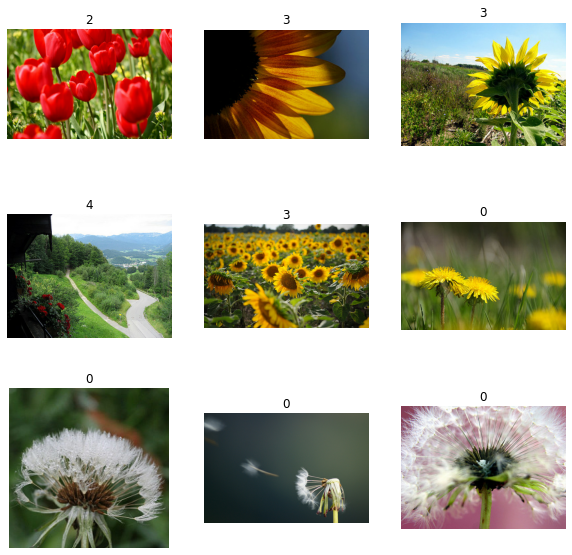

In [7]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building and training

In [0]:
def get_training_model(optimizer=tf.keras.optimizers.Adam()):
    resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=False)

    model = tf.keras.Sequential([
        resnet50,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(5)
    ])

    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
    
    return model

In [10]:
wandb.init(project="scl", entity="authors", id="fully-supervised-flowers")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

model = get_training_model()

start = time.time()
model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback(), es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
49/49 [==============================] - 28s 579ms/step - loss: 1.7359 - accuracy: 0.4785 - val_loss: 2.5537 - val_accuracy: 0.2036
Epoch 2/50
49/49 [==============================] - 23s 468ms/step - loss: 1.1367 - accuracy: 0.5779 - val_loss: 2.7236 - val_accuracy: 0.2036
Epoch 3/50
49/49 [==============================] - 23s 470ms/step - loss: 1.0860 - accuracy: 0.6173 - val_loss: 3.5597 - val_accuracy: 0.2036
Epoch 00003: early stopping


What happens if we don't incorporate the `EarlyStopping` callback?

In [11]:
wandb.init(project="scl", entity="authors", id="fully-supervised-flowers-no-es")

no_es_model = get_training_model()

start = time.time()
no_es_model.fit(train_ds,
          validation_data=validation_ds,
          epochs=50,
          callbacks=[WandbCallback()])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/50
15/49 [========>.....................] - ETA: 14s - loss: 4.2058 - accuracy: 0.2990

wandb: Network error resolved after 0:00:20.607880, resuming normal operation.


49/49 [==============================] - 27s 549ms/step - loss: 2.4795 - accuracy: 0.4272 - val_loss: 139772.0312 - val_accuracy: 0.1727
Epoch 2/50
49/49 [==============================] - 26s 529ms/step - loss: 1.2901 - accuracy: 0.5263 - val_loss: 1.7027 - val_accuracy: 0.2673
Epoch 3/50
49/49 [==============================] - 24s 482ms/step - loss: 1.0833 - accuracy: 0.5990 - val_loss: 1.7696 - val_accuracy: 0.3273
Epoch 4/50
49/49 [==============================] - 23s 476ms/step - loss: 1.0224 - accuracy: 0.6224 - val_loss: 1.7315 - val_accuracy: 0.3527
Epoch 5/50
49/49 [==============================] - 23s 475ms/step - loss: 1.0015 - accuracy: 0.6455 - val_loss: 1.9583 - val_accuracy: 0.3509
Epoch 6/50
49/49 [==============================] - 26s 531ms/step - loss: 0.9130 - accuracy: 0.6474 - val_loss: 1.5542 - val_accuracy: 0.4436
Epoch 7/50
49/49 [==============================] - 26s 525ms/step - loss: 0.8414 - accuracy: 0.6801 - val_loss: 1.2269 - val_accuracy: 0.4800
Epoch